# Chapter 3

## 3.1 MNIST 

손글씨를 분류 해보자. 머신러닝 분야의 'Hello Wolrd'라고 불리는 MNIST는 이미지 별로 숫자를 나타내는 레이블이 되어 있고, 이 각각의 이미지를 분류 해서 어느정도 인식을 하는지 알아보려 한다. 
 사이킷런에서 제공하는 여러 함수를 사용해 잘 알려진 데이터셋을 내려받자. MNIST도 그중 하나. 다음의 코드를 사용해서  MNIST 데이터 셋을 내려 받는걸로 시작해보자.

In [25]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

사이킷런에서 읽어들인 데이터 셋들은 잉ㄹ반적으로 비슷한 딕셔너리 구조를 가지고 있다. 

- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배여을 가진 data 키
- 레이블 배열을 담은 target 키 

다음 배열들을 살펴 보도록 하자.

In [8]:
X, y = mnist["data"], mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있다. 이미지가 28x28픽셀이기 때문. 개개의 특성은 단순히 0 (흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다. 데이터셋에서 이미지 하나를 확인해보자. 샘플의 특성 벡터를 추출해서 28 x 28 배열로 크기를 바꾸고 맵플롯립의 imshow()함수를 사용해 그리면 된다.

<function matplotlib.pyplot.show(*args, **kw)>

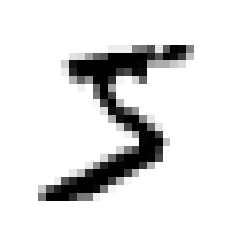

In [34]:
import matplotlib as mlp
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show

숫자 5로 보이는데, 실제 레이블은 다음과 같다.

In [22]:
y[0]

'5'

레이블은 문자열이고,  대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환 시키자.

In [26]:
y = y.astype(np.uint8)

그림 저장: more_digits_plot


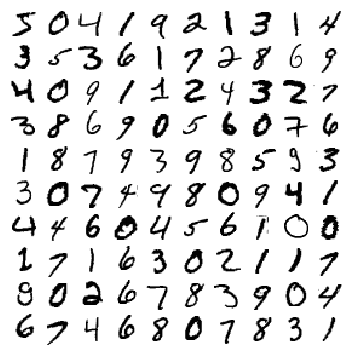

In [32]:
## 책에 없는 내용 
## 출처: https://github.com/rickiepark/handson-ml2/blob/master/03_classification.ipynb

def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = mpl.cm.binary, 
              interpolation = "nearest")
    plt.axis("off")

# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) -1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
   
plt.figure(figsize=(5,5))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

이제 데이터를 조사하기 위해 테스트셋을 따로 떼어 놓자.

In [33]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련 

문제를 단순화해서 하나의 숫자, 예를 들어 5만 식별 해보자. 이제 5와 5가 아닌것을 분류하게 될것이다.

In [36]:
y_train_5 = (y_train == 5) # 5면 True, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

이제 분류 모델을 하나 선택해서 훈련시켜보자. 사이킷런의 SGDClassifier클래스를 사용해 확률적 졍사 하강법 분류기로 시작해보려 한다. 이 부류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있다. SGD모델이 한번에 하나씩 훈련 샘플을 독림적으로 처리하기 때문이라고 한다.

In [38]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

이제 이 모델을 사용해서 숫자 5의 이미지를 분류 해보자. 아까 보았던 5이미지를 some_digit로 지정 해두었고 이를 파악 해보는것이다.

In [40]:
sgd_clf.predict([some_digit])

array([ True])

결과는 성공. 이제 이 모델의 성능을 평가해보자.

## 3.3 성능 측정

분류기 평가는 회귀 모델보다 훨신 어렵기 때문에 이 

## 3.4 다중 분류

지금껏 이진 분류를 했으니 다중 또는 다항 분류기를 사용해서 둘 이상의 클래스를 분류 해보자. 

(SGD, 랜덤포레스트, 나이브베이즈 같은) 일부 알고리즘은 여러 개의 클래스를 직접 저리할 수 있는 반면, (로지스틱 회귀나 서포트 벡터 머신 분류기 같은)다른 알고리즘은 이진 분류만 가능하다. 하지만 이 이진 분류기를 여러 개 사용해서 다중 클래스를 분류 하는 기법도 많다.

예를 들어 특정 숫자 하나만 구분 하는 숫자별 이진 분류기 10개(0~9)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있습니다. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 된다. 이를 OvR(one-versus-the-rest)전략 이라고 한다. (또는 One-versus-all).

또 다른 전략은 0